In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')

import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
from torch.autograd import Variable
from captum.attr import IntegratedGradients

from dataset import Dataset
from net import define_network

In [2]:
torch.manual_seed(123)
np.random.seed(123)

In [3]:
def evaluate(eval_file, model_file, gene_name):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()
    ig = IntegratedGradients(model)

    _datas = np.load(eval_file, allow_pickle=True)
    important_genes = dict(Astro=dict(), Endo=dict(), OPC=dict(), ODC=dict())
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'ODC':
            continue
        _important_genes = important_genes[_datas[index-1]['cell_type']]
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1) / 10
        
        attributions = torch.zeros(input.reshape(-1).shape).cuda()
        for i in range(target.shape[-1]):
            attributions += ig.attribute(input, target=(0, i))[0, 0].reshape(-1)
        attributions = attributions.cpu().detach().numpy()
        for i in range(len(attributions)):
            if i not in _important_genes.keys():
                _important_genes[i] = 0
            _important_genes[i] += attributions[i]
        
    return important_genes

important_genes = evaluate(
    '/lmh_data/data/sclab/sclab/eval_dataset.npy',
    '/lmh_data/data/sclab/sclab/tmp/QKI/model_epoch_10.pth', 'QKI')
important_genes

{'Astro': {},
 'Endo': {},
 'OPC': {},
 'ODC': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.01824817224405706,
  16: 0.0,
  17: 0.0,
  18: 0.0,
  19: -0.039310782216489315,
  20: -0.01234698947519064,
  21: 0.0,
  22: -0.030373286455869675,
  23: 0.0,
  24: -0.11539691127836704,
  25: 0.0,
  26: 0.11889262683689594,
  27: 0.0,
  28: 0.0,
  29: 0.0,
  30: 0.0,
  31: 0.0,
  32: 0.0,
  33: 0.0,
  34: -8.72242003424617e-05,
  35: -0.017707687336951494,
  36: 0.0,
  37: -0.04016169824171811,
  38: -0.02644974202848971,
  39: 0.02163782116258517,
  40: 0.030525154899805784,
  41: 0.19385847030207515,
  42: 0.0,
  43: -0.035398929147049785,
  44: 0.0,
  45: -0.19508766196668148,
  46: -0.29783351719379425,
  47: -0.10845826799049973,
  48: 0.021230977901723236,
  49: -0.015614066738635302,
  50: 0.15951780322939157,
  51: -0.03230683133006096,
  52: 0.02947445958852768,
  53: 0

In [4]:
scRNA_head = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)[0]['scRNA_head']

def find_special_genes(important_genes, cell_type):
    genes = pd.DataFrame(
        sorted(important_genes[cell_type].items(), key=lambda x: x[1], reverse=True), columns=['index', 'value']
    ).set_index('index')
    genes = genes.sort_values(by=['value'], ascending=False)
    return genes

genes = find_special_genes(important_genes, 'ODC')
genes['name'] = scRNA_head[list(genes.index)]
genes.to_csv('tmp/related_genes_QKI.csv')
genes

,value,name
index,,
18428,145.530614,PCDH9
15794,65.513742,MALAT1
28301,62.772109,PLP1
28113,48.950732,XIST
15663,45.476852,FTH1
...,...,...
726,-22.476484,RNF220
23880,-24.063360,MBP
21156,-29.815283,RBFOX1


In [5]:
genes = genes[:100]
gene_names = genes.name.values
gene_names

array(['PCDH9', 'MALAT1', 'PLP1', 'XIST', 'FTH1', 'PDE4B', 'SPOCK3',
       'ANK2', 'ST18', 'KIRREL3', 'PHLPP1', 'MARCH1', 'ZBTB20', 'ALCAM',
       'PIP4K2A', 'EDIL3', 'TRIM2', 'TMTC2', 'PTPRD', 'IL1RAPL1', 'AUTS2',
       'NPAS3', 'ERBB4', 'FOLH1', 'FRMD5', 'PLXDC2', 'FTX', 'FAR1',
       'MYRF', 'NKAIN2', 'QKI', 'ANKS1B', 'FBXL7', 'MBNL2', 'CACNA2D1',
       'NTM', 'SLAIN1', 'N4BP2L2', 'SLCO3A1', 'ZSWIM6', 'CNP', 'FGFR2',
       'DMD', 'TBC1D5', 'DOCK3', 'TJP1', 'TTLL7', 'USP47', 'CALM2',
       'NCAM1', 'GRIA4', 'DOCK4', 'RERE', 'EXOC6B', 'DOCK5', 'TMEFF2',
       'RTN4', 'ADIPOR2', 'LSAMP', 'MYO1D', 'ERMN', 'NFIA', 'UGT8',
       'MAGI2', 'GRID1', 'OSBP2', 'NEGR1', 'SEPT7', 'SOX2-OT', 'GAB2',
       'USP54', 'LAMP2', 'TMEM165', 'POLR2F', 'PLEKHH1', 'SPOCK1',
       'PRUNE2', 'ZNF638', 'ELF1', 'DOCK9', 'GNAQ', 'C12orf76', 'SEMA6A',
       'CTNNA3', 'MOBP', 'MAGI1', 'FRYL', 'JPX', 'PICALM', 'FBXO7',
       'CDKAL1', 'SRPK2', 'PHF14', 'CRYAB', 'HSPA1A', 'FAM107B', 'GRIA2',
       'PD

In [6]:
literome = pd.read_csv('/lmh_data/data/sclab/source/literome/pathway-extraction.txt', sep='\t')

def get_filter(gene_name, num=0):
    if num == 2:
        return pd.DataFrame()
    _filter_Causes = literome[literome.Theme.str.contains(gene_name)].Cause.str.split(':').str[-1].str.split('_')
    _filter_Themes = literome[literome.Cause.str.contains(gene_name)].Theme.str.split(':').str[-1].str.split('_')
    _filter_genes = set()
    for _filter in pd.concat([_filter_Causes, _filter_Themes]).values:
        _filter_genes = _filter_genes | set(_filter)
    _filters = [get_filter(_name, num+1) for _name in _filter_genes]
    _filters.append(_filter_Causes)
    _filters.append(_filter_Themes)
    return pd.concat(_filters)

_filters = get_filter('QKI')

In [7]:
_filter_genes = set()
for _filter in _filters.values:
    _filter_genes = _filter_genes | set(_filter[0])
print(len(_filter_genes & set(gene_names)) / len(gene_names))
_filter_genes & set(gene_names)

0.25


{'ADIPOR2',
 'ANK2',
 'CALM2',
 'CNP',
 'CRYAB',
 'DMD',
 'DOCK3',
 'ERBB4',
 'FOLH1',
 'GAB2',
 'GRIA2',
 'MAGI1',
 'MARCH1',
 'MOBP',
 'NCAM1',
 'NTM',
 'PDE4B',
 'PLP1',
 'POLR2F',
 'QKI',
 'SEPT7',
 'ST18',
 'TJP1',
 'TMEM165',
 'UGT8'}

In [8]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(eval_file, model_file, gene_name, ignore_genes_index):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()

    _datas = np.load(eval_file, allow_pickle=True)
    pearsons = []
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'ODC':
            continue
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1).cpu().numpy()
        
        _shape = input.shape
        input = input.reshape(-1)
        input[ignore_genes_index] = 0
        input = input.reshape(_shape)
        output = model(input).detach().cpu().numpy()
        
        pearson = stats.pearsonr(output[0, 0], target[0, 0])[0]
        pearsons.append(pearson)
        
    return pearsons

In [9]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/tmp/QKI/model_epoch_10.pth', 'QKI', list(genes.index)[:i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

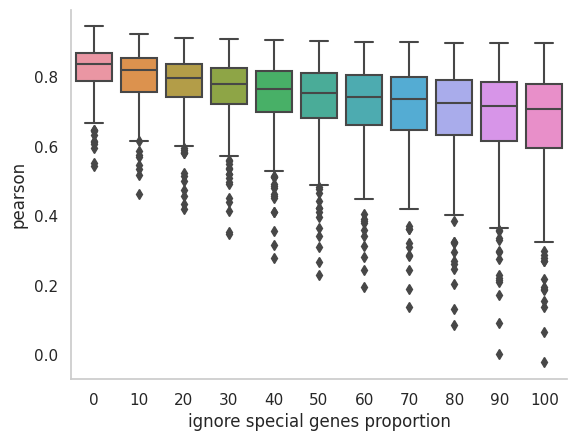

In [10]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

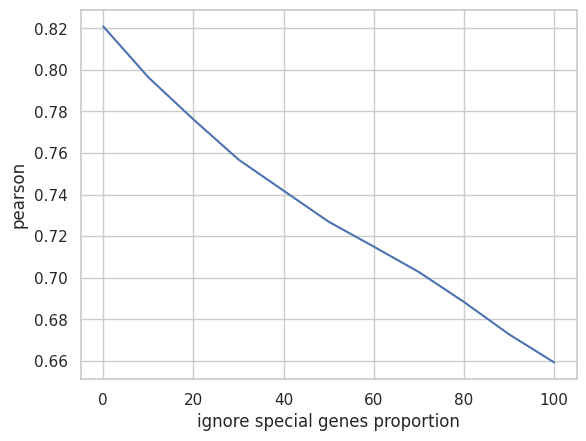

In [11]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

In [12]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/tmp/QKI/model_epoch_10.pth', 'QKI', list(genes.index)[max(i-10, 0):i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

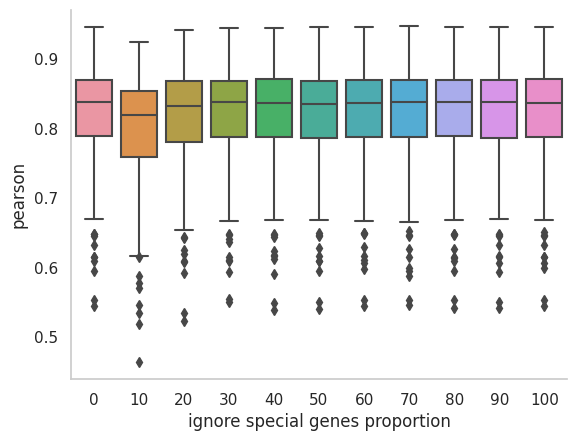

In [13]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

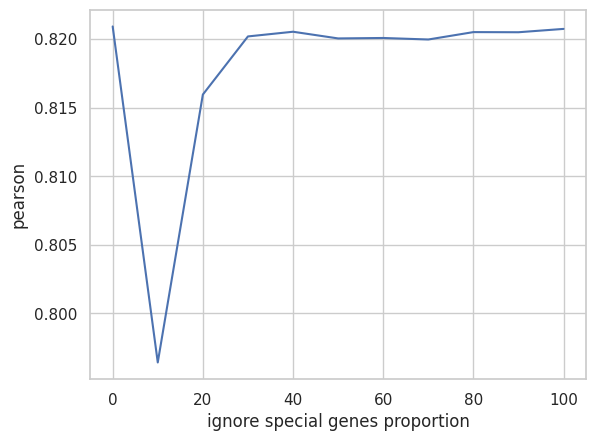

In [14]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

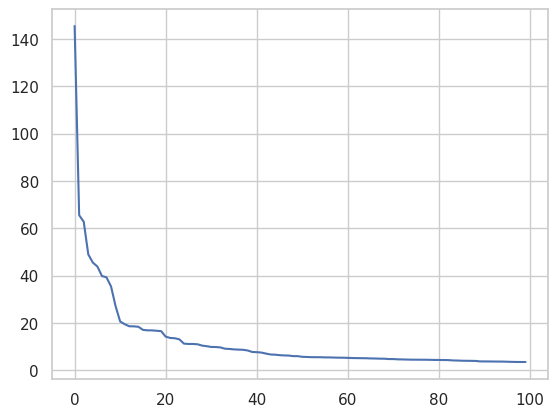

In [15]:
y = genes.value.values.flatten()

x = [i for i in range(len(y))]
plt.plot(x, y)